# Neuron networks from scratch in Python
References: http://103.203.175.90:81/fdScript/RootOfEBooks/E%20Book%20collection%20-%202024%20-%20G/CSE%20%20IT%20AIDS%20ML/Neural%20Network.pdf

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

## Chapter 9: Backpropagation

### 9.1 Backpropagation from ReLU

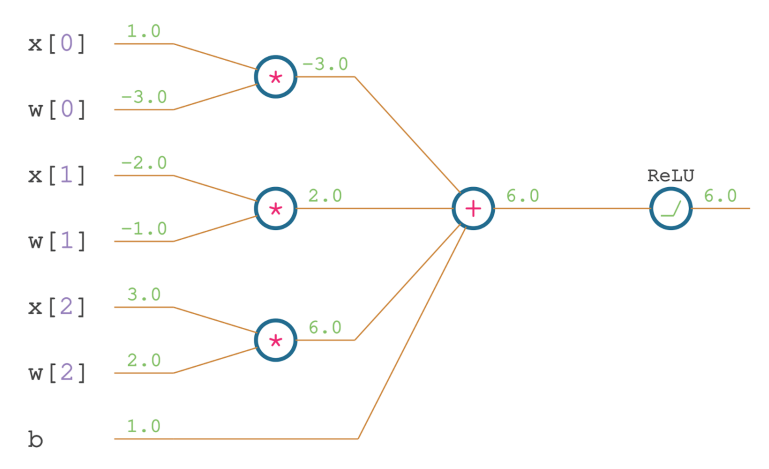

In [74]:
# Python
x = [1.0, -2.0, 3.0]
w = [-3.0, -1.0, 2.0]
b = 1.0

xw = [x[i] * w[i] for i in range(len(x))]
z = sum(xw) + b

y = max(z, 0)

drelu_dz = (1.0 if z > 0 else 0.)
dz_dxiwi = [1.0, 1.0, 1.0]
dz_db = 1
dxiwi_dwi = x.copy()
dxiwi_dxi = w.copy()

drelu_dxi = [drelu_dz * dz_dxiwi[i] * dxiwi_dxi[i] for i in range(len(x))]
drelu_dwi = [drelu_dz * dz_dxiwi[i] * dxiwi_dwi[i] for i in range(len(x))]
drelu_db = drelu_dz * dz_db

print(f'drelu / dx_i = {drelu_dxi}')
print(f'drelu / dw_i = {drelu_dwi}')
print(f'drelu / db = {drelu_db}')

drelu / dx_i = [-3.0, -1.0, 2.0]
drelu / dw_i = [1.0, -2.0, 3.0]
drelu / db = 1.0


In [75]:
lr = 0.001
w_updated = [w[i] - (lr * drelu_dwi[i]) for i in range(len(x))]
b_updated = b - (lr * drelu_db)

z_updated = sum(w_updated[i] * x[i] for i in range(len(x))) + b

y_updated = max(0, z_updated)
print(round(y_updated, 3))

5.986


In [76]:
# Numpy
import numpy as np

x = np.array([[1, 2, 3, 2.5],
            [2., 5., -1., 2],
            [-1.5, 2.7, 3.3, -0.8]])


w = np.array([[0.2, 0.8, -0.5, 1],
            [0.5, -0.91, 0.26, -0.5],
            [-0.26, -0.27, 0.17, 0.87]])

b = np.array([[2, 3, 0.5]])

z = np.dot(x, w.T) + b

y = np.maximum(0, z)

drelu = y.copy()
drelu = (z > 0).astype(float)

dx = np.dot(drelu, w)
dw = np.dot(drelu, x)
db = np.sum(drelu, axis=0, keepdims=True)

print(dx)
print(dw)
print(db)


[[ 0.44 -0.38 -0.07  1.37]
 [-0.06  0.53 -0.33  1.87]
 [ 0.44 -0.38 -0.07  1.37]]
[[ 1.5  9.7  5.3  3.7]
 [-0.5  4.7  6.3  1.7]
 [ 1.5  9.7  5.3  3.7]]
[[3. 2. 3.]]


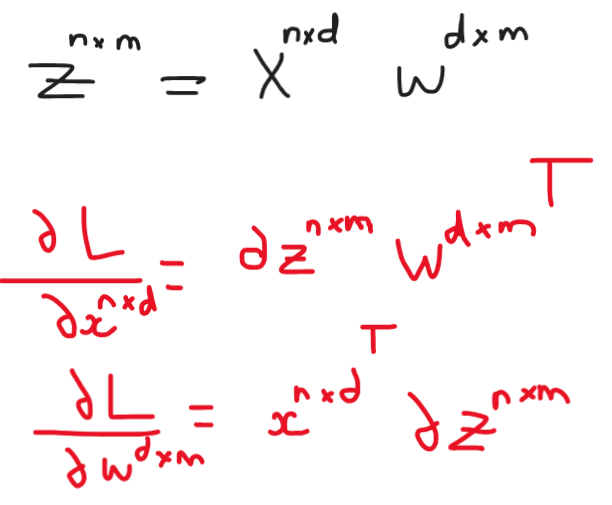

### 9.2 Categorical Cross-Entropy loss derivative

In [77]:
class Loss:
    def calculate(self, y_pred, y_true):
        return np.mean(self.forward(y_pred, y_true))
    
class CategoricalCrossEntropy(Loss):
    def backward(self, y_pred, y_true):
        samples = len(y_pred)
        labels = len(y_pred[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = (-y_true / y_pred) / samples

### 9.3 Softmax activation derivative code implementation

In [78]:
class Softmax:
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for i, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)

            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            self.dinputs[i] = np.dot(jacobian, single_dvalues)

### 9.4 Common Categorical Cross-Entropy loss and Softmax activation derivative

In [79]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Softmax()
        self.loss = CategoricalCrossEntropy()
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

### Implement

In [80]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

class Activation_Softmax_Loss_CategoricalCrossentropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples


In [81]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 3)

activation1 = Activation_ReLU()


dense2 = Layer_Dense(3, 3)

loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

dense1.forward(X)


activation1.forward(dense1.output)


dense2.forward(activation1.output)


loss = loss_activation.forward(dense2.output, y)
print(dense2.output[:5])
print(loss_activation.output[:5])

print('loss:', loss)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)

print('acc:', accuracy)

loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-1.8183968e-07 -1.5235776e-07  1.2281279e-06]
 [-5.0631292e-07 -4.2422371e-07  3.4195891e-06]
 [-8.4041352e-07 -7.0415609e-07  5.6760728e-06]
 [-1.1393766e-06 -9.5464793e-07  7.6952419e-06]]
[[0.33333334 0.33333334 0.33333334]
 [0.3333332  0.3333332  0.33333364]
 [0.3333329  0.33333293 0.3333342 ]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
loss: 1.0986104
acc: 0.34
[[ 1.5766357e-04  7.8368583e-05  4.7324400e-05]
 [ 1.8161038e-04  1.1045573e-05 -3.3096312e-05]]
[[-3.60553473e-04  9.66117223e-05 -1.03671395e-04]]
[[ 5.44109462e-05  1.07411419e-04 -1.61822361e-04]
 [-4.07913431e-05 -7.16780924e-05  1.12469446e-04]
 [-5.30112993e-05  8.58172934e-05 -3.28059905e-05]]
[[-1.0729185e-05 -9.4610732e-06  2.0027859e-05]]


In [82]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

In [83]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        self.dinputs = np.dot(dvalues, self.weights.T)

class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

        self.dinputs[self.inputs <= 0] = 0

class Softmax:
    def forward(self, inputs):
        self.inputs = inputs

        exp_val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_val / np.sum(exp_val, axis=1, keepdims=True)

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for i, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = np.reshape(-1, 1)

            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            self.dinputs[i] = np.dot(jacobian, single_dvalues)

class Loss:
    def calculate(self, y_pred, y_true):
        return np.mean(self.forward(y_pred, y_true))
    
class CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        classes = len(y_pred[0])

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(len(y_pred)), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        return - np.log(correct_confidences)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        classes = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(classes)[y_true]

        return y_true / dvalues / samples

class Softmax_CategoricalCrossEntropy:
    def __init__(self):
        self.activation = Softmax()
        self.loss = CategoricalCrossEntropy()
    
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs /= samples

In [84]:
X, y = spiral_data(samples=100, classes=3)
dense1 = Dense(2, 3)
activation1 = ReLU()
dense2 = Dense(3, 3)
loss_activation = Softmax_CategoricalCrossEntropy()

dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y)

print(loss_activation.output[:5])
print('Loss:', loss)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)

print('Acc:', accuracy)

loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

[[0.33333334 0.33333334 0.33333334]
 [0.3333332  0.3333332  0.33333364]
 [0.3333329  0.33333293 0.3333342 ]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
Loss: 1.0986104
Acc: 0.34
[[ 1.5766357e-04  7.8368583e-05  4.7324400e-05]
 [ 1.8161038e-04  1.1045573e-05 -3.3096312e-05]]
[[-3.60553473e-04  9.66117223e-05 -1.03671395e-04]]
[[ 5.44109462e-05  1.07411419e-04 -1.61822361e-04]
 [-4.07913431e-05 -7.16780924e-05  1.12469446e-04]
 [-5.30112993e-05  8.58172934e-05 -3.28059905e-05]]
[[-1.0729185e-05 -9.4610732e-06  2.0027859e-05]]
